In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import yfinance as yf
from datetime import date, timedelta
from tqdm import tqdm
from texttable import Texttable
from scipy.stats import linregress
from pyti import chande_momentum_oscillator as cmo
from pyti import bollinger_bands as bb
from pyti import on_balance_volume as obv
from pyti import moving_average_convergence_divergence as macd
from pyti import exponential_moving_average as ema
from scipy.optimize import minimize
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
plt.rcParams['figure.figsize'] = (22,10)

In [3]:
nacionales = ['AC', 'ACTINVRB', 'ALFAA', 'ALPEKA', 'ALSEA', 'AMXL', 'ARA', 'ASURB', 'AXTELCPO', 'AZTECACPO', 'BACHOCOB', 'BBAJIOO', 'BIMBOA',
              'BOLSAA', 'BSMXB', 'CEMEXCPO', 'CHDRAUIB', 'CREAL', 'CUERVO', 'DANHOS13', 'ELEKTRA', 'FEMSAUBD', 'FIBRAMQ12', 'FIBRAPL14', 
              'FIHO12', 'FUNO11', 'GAPB', 'GCARSOA1', 'GCC', 'GENTERA', 'GFINBURO', 'GFNORTEO', 'GMEXICOB', 'GMXT', 'GRUMAB', 'HCITY',
              'HERDEZ', 'ICHB', 'IENOVA', 'KIMBERA', 'LABB', 'LALAB', 'LIVEPOLC-1', 'MEGACPO', 'NEMAKA', 'OMAB', 'PE&OLES', 'PINFRA', 'Q', 
              'RA', 'SITESB-1', 'SPORTS', 'TERRA13', 'TLEVISACPO', 'UNIFINA', 'VESTA', 'VOLARA', 'WALMEX']

In [4]:
extranjeras = ['AAPL', 'AMD', 'AMZN', 'BA', 'BABAN', 'BAC', 'BRKB', 'CHK', 'CRM', 'DIS', 'FB', 'FCX', 'GE', 'GOOGL', 'INTC', 
               'JPM', 'MGM', 'MSFT', 'MU', 'NFLX', 'NKE', 'NVDA', 'PYPL', 'SBUX', 'TCEHYN', 'TSLA', 'TWTR', 'UNH', 'V', 'X']

In [5]:
tracks = ['ACWI', 'ANGELD10', 'BIL', 'CETETRCISHRS', 'CORPTRCISHRS', 'DIABLOI10', 'DLRTRAC15', 'EDC', 'EDZ', 'EEM', 'EWJ', 'EWZ', 'FAS', 'FAZ', 
          'FLOT', 'GLD', 'IAU', 'IVV', 'IVVPESOISHRS', 'MEXTRAC09', 'NAFTRACISHRS', 'QQQ', 'SHV', 'SHY', 'SPY']

In [6]:
# stocks_info = { s : yf.Ticker(s + '.MX') for s in nacionales + extranjeras + tracks}
# pd.to_pickle(stocks_info, '../Reto_Actinver/stocks_info.pickle')
stocks_info = pd.read_pickle('stocks_info.pickle')

In [7]:
def update_stocks(save=True):
    
    all_stocks = nacionales + extranjeras + tracks
    stock_data = {}
    
    for stock in tqdm(all_stocks):
        # Stock History
        stock_hist = yf.Ticker(stock + '.MX').history(period='max')
        # Stock Calculations
        stock_hist['Total_traded'] = stock_hist['Open'] * stock_hist['Volume']
        stock_hist['Daily_return'] = stock_hist['Close'].pct_change(1) 
        stock_hist['Cum_daily_return'] = (stock_hist['Daily_return'] + 1).cumprod()
        stock_hist['Max_Norm'] = stock_hist['Close'] / stock_hist['Close'][0] 
        stock_hist['5y_Norm'] = stock_hist['Close'] / stock_hist['Close'][stock_hist['Close'].index.year >= 2014][0]
        stock_hist['1y_Norm'] = stock_hist['Close'] / stock_hist['Close'][stock_hist['Close'].index.year >= 2019][0]
        # Finantial Indicators
        stock_hist['Moving_Average'] = stock_hist['Close'].rolling(15).mean() 
        stock_hist['Upper_BB'] = stock_hist['Close'].rolling(15).mean() + 2 * stock_hist['Close'].rolling(15).std()             
        stock_hist['Lower_BB'] = stock_hist['Close'].rolling(15).mean() - 2 * stock_hist['Close'].rolling(15).std()             
        stock_hist['ChandeMO'] = cmo.chande_momentum_oscillator(stock_hist['Close'], 9)                         
        stock_hist['MACD'] = macd.moving_average_convergence_divergence(stock_hist['Close'], 12, 26)    
        stock_hist['SIGNAL'] = ema.exponential_moving_average(stock_hist['MACD'], 9)
        stock_hist['OBV'] = obv.on_balance_volume(stock_hist['Close'], stock_hist['Volume'])
        
        stock_data[stock] = stock_hist
        
    if save:
        pd.to_pickle(stock_data, '../Reto_Actinver/stocks_data.pickle')
        
    return stock_data

In [8]:
stocks = update_stocks()

100%|██████████| 113/113 [06:47<00:00,  3.76s/it]


In [9]:
def get_trends(s_names, show=False, plot=False, by='Close'):
    
    table = Texttable()
    header = ['Stock', 
              'Slope_120', 'Above_Points_120',
              'Slope_90', 'Above_Points_90',
              'Slope_60', 'Above_Points_60',
              'Slope_30', 'Above_Points_30',
              'Slope_15', 'Above_Points_15',
              'Slope_7', 'Above_Points_7',]
    table.header(header)
    slopes = []
    
    for s in s_names:
        trend = [s]
        
        for t in [120, 90, 60, 30, 15, 7]:
            trend.append(linregress(range(t), stocks[s][by][-t:])[0])
            trend.append((stocks[s]['Close'] > stocks[s]['Moving_Average'])[-t:].sum())
            
        table.add_row(trend)
        slopes.append(trend)
    
    if show:
        print(table.draw())
        
    slopes = pd.DataFrame(slopes, columns=header)   
    slopes.set_index('Stock', inplace=True)
    
    if plot:
        fig, axes = plt.subplots(10, 4, figsize=(22,22))
        k = 0
        for t in [60, 30, 15, 7]:
            sn = slopes.sort_values(by=f'Slope_{t}', ascending=False).head(10).index.tolist()
            for n in range(len(sn)):
                sd = stocks[sn[n]].iloc[-t:]
                axes[n,k].plot(sd['Close'], '.')
                axes[n,k].plot(sd['Moving_Average'], 'w')
                axes[n,k].fill_between(sd['Close'].index, sd['Upper_BB'], sd['Lower_BB'], alpha=0.25)
                axes[n,k].set_ylabel(sn[n])
                if n == 0:
                    axes[n,k].set_title(f'{t}d Interval')
            k += 1
        plt.tight_layout()
    
    return slopes 

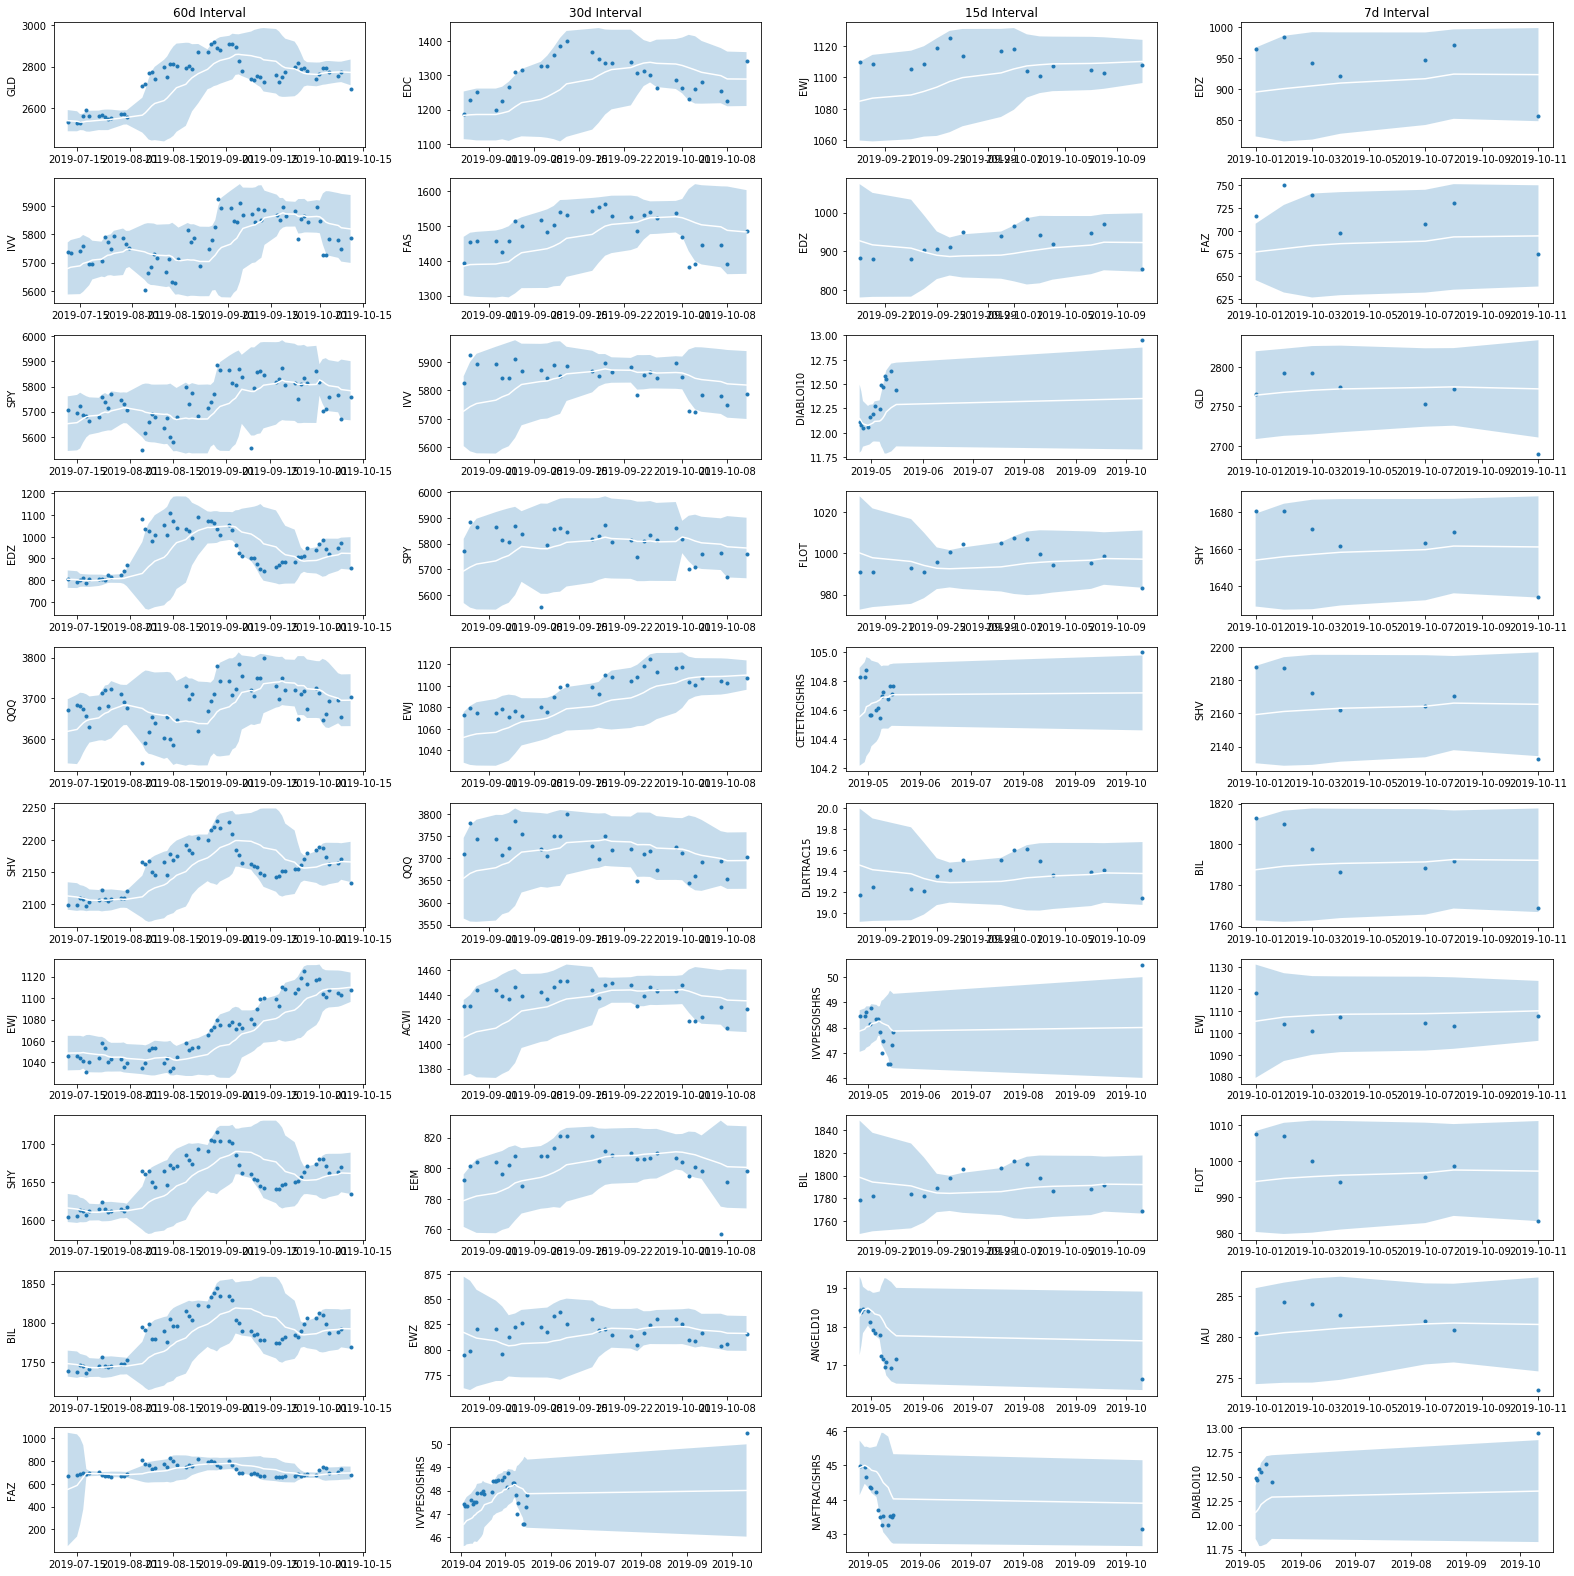

In [34]:
slps = get_trends(tracks, plot=True, by='Moving_Average')

In [11]:
def analyse_stock(stock, day=False):
    
    plt.figure(figsize=(22,12))
    
    # Max History Plot
    plt.subplot(531)
    plt.plot(stock['Close'])
    plt.fill_between(stock['Close'].index, stock['Upper_BB'], stock['Lower_BB'], alpha=0.25)
    plt.ylabel('Max History')
    
    # 5y History Plot
    plt.subplot(532)
    stock_5y = stock[stock.index.year >= 2014]
    plt.plot(stock_5y['Close'])
    plt.fill_between(stock_5y['Close'].index, stock_5y['Upper_BB'], stock_5y['Lower_BB'], alpha=0.25)
    plt.ylabel('5y History')
    
    # 1y History Plot
    plt.subplot(533)
    stock_1y = stock[stock.index > str(date.today() - timedelta(365))]
    plt.plot(stock_1y['Close'])
    plt.fill_between(stock_1y['Close'].index, stock_1y['Upper_BB'], stock_1y['Lower_BB'], alpha=0.25)
    plt.ylabel('1y History')
    
    fig, axes = plt.subplots(4, 1, sharex=True, figsize=(22, 16))
    fig.subplots_adjust(hspace=0)
    
    for i in range(4):
        if i == 0:
            # 120d History Plot
            stock_150d = stock[stock.index > str(date.today() - timedelta(120))]
            axes[i].plot(stock_150d['Close'], '.')
            axes[i].plot(stock_150d['Moving_Average'], 'w')
            axes[i].fill_between(stock_150d['Close'].index, stock_150d['Upper_BB'], stock_150d['Lower_BB'], alpha=0.25)
            if day:
                axes[i].plot(pd.to_datetime(day), stock_150d['Close'][day], c='r', marker='o', ms=10, alpha=0.5)
            axes[i].set_ylabel('120d History')
        elif i == 1:
            # Chande Momentum Oscillator Plot
            axes[i].plot(stock_150d['ChandeMO'][-120:])
            axes[i].hlines(0, stock_150d['ChandeMO'][-120:].index[0], stock_150d['ChandeMO'][-120:].index[-1], 'r')
            axes[i].set_ylabel('Chande Momentum Oscillator')
        elif i == 2:
            # MACD Plot
            axes[i].plot(stock_150d['MACD'][-120:], 'b')
            axes[i].plot(stock_150d['SIGNAL'][-120:], 'r')
            axes[i].set_ylabel('MACD')
        elif i == 3:
            # On Balance Volume Plot
            axes[i].plot(stock_150d['OBV'][-120:])
            axes[i].set_ylabel('On Balance Volume')
    
plt.tight_layout()

<Figure size 1584x720 with 0 Axes>

In [12]:
# slps.sort_values(by=['Slope_7'], ascending=False).head(15)

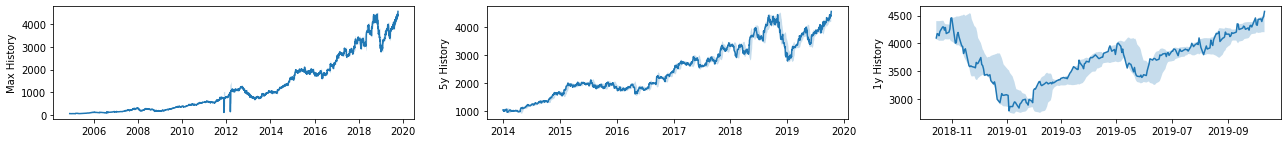

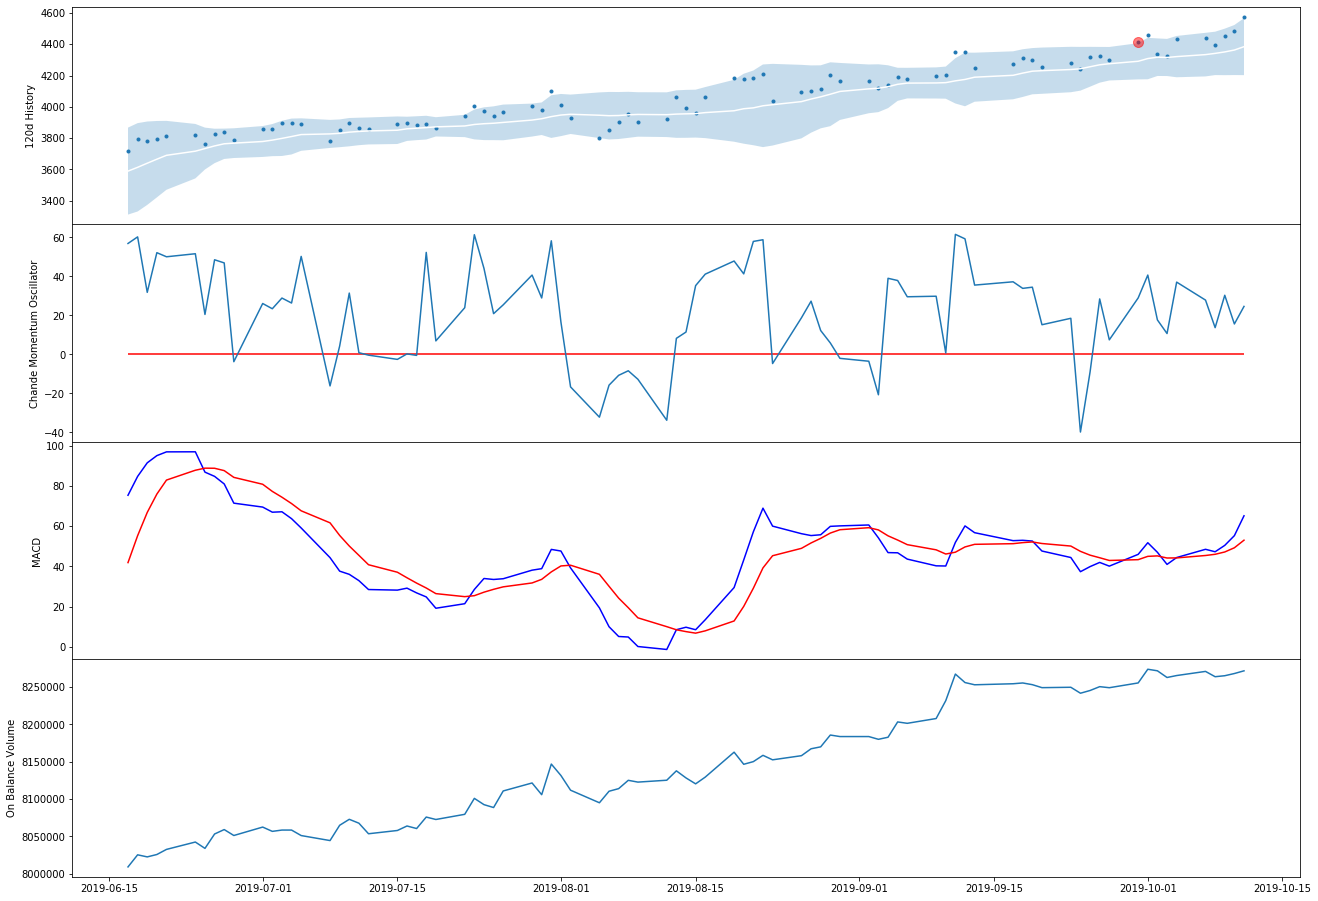

In [31]:
analyse_stock(stocks['AAPL'], day='2019-09-30')

In [16]:
for i in ['AXTELCPO', 'FIBRAMQ12', 'FIBRAPL14', 'GMXT', 'ALSEA', 'V', 'TERRA13', 'SITESB-1', 'LABB', 'FUNO11', 'AAPL', 'NKE', 'Q', 'GAPB', 'MEGACPO', 'AC']:
    print(i,':', (stocks[i]['Close'][-1] / stocks[i]['Close'][-5] - 1) * 100)

AXTELCPO : 5.964915157281814
FIBRAMQ12 : 2.6602170964095118
FIBRAPL14 : -1.3157916751484144
GMXT : -2.0782404639567043
ALSEA : 4.5117690641528485
V : 0.6085819145948079
TERRA13 : 2.1618075092307842
SITESB-1 : 3.52760766482092
LABB : -0.3171219117359292
FUNO11 : 5.166434685280197
AAPL : 0.37255146108954307
NKE : -1.751352671030404
Q : 2.9764432621220527
GAPB : 2.9436607563699146
MEGACPO : 5.108842954863402
AC : 2.4749221289637413


In [44]:
# To Invest: SITESB-1, LABB, FUNO11, AAPL, NKE, Q, GAPB, MEGACPO, AC
# To Sell: FIBRAPL14, GMXT, V
stocks_selected = ['AXTELCPO', 'FUNO11', 'SITESB-1', 'FIBRAMQ12', 'Q', 'ALSEA', 'TERRA13']

In [50]:
def optimize_portfolio(ssl, plot=False):
    
    ss = pd.concat([stocks[s]['Close'] for s in ssl], axis = 1)
    ss.columns = ssl
    
    ss_norm = pd.DataFrame()
    for c in ssl:
        index = ss[c].first_valid_index()
        ss_norm[f'{c}_Normalized'] = ss[c] / ss[c][index]
    
    # ss_return = ss.pct_change(1)
    log_ret = np.log(ss[ss.index.year == 2019]/ss[ss.index.year == 2019].shift(1))
    
    # Monte Carlo Simulation
    
    num_ports = 30000

    all_weights = np.zeros((num_ports,len(ss.columns)))
    ret_arr = np.zeros(num_ports)
    vol_arr = np.zeros(num_ports)
    sharpe_arr = np.zeros(num_ports)

    for ind in tqdm(range(num_ports)):
        weights = np.array(np.random.random(7))                                             # Create Random Weights
        weights = weights / np.sum(weights)                                                 # Rebalance Weights
        all_weights[ind,:] = weights                                                        # Save Weights
        ret_arr[ind] = np.sum((log_ret.mean() * weights) *252)                              # Expected Return
        vol_arr[ind] = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))     # Expected Variance
        sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]                                         # Sharpe Ratio
        
    weights_bsr = all_weights[sharpe_arr.argmax(), :]                                       # Weights for the best Sharpe Ratio
    weights_brr = all_weights[ret_arr.argmax(), :]                                          # Weights for the max returns
        
    # Mathematical Optimization
    
    def get_ret_vol_sr(weights):
        """
        Takes in weights, returns array of return,volatility, sharpe ratio
        """
        weights = np.array(weights)
        ret = np.sum(log_ret.mean() * weights) * 252
        vol = np.sqrt(np.dot(weights.T, np.dot(log_ret.cov() * 252, weights)))
        sr = ret/vol
        return np.array([ret,vol,sr])
    
    def neg_sharpe(weights):
        return  get_ret_vol_sr(weights)[2] * -1

    # Contraints
    def check_sum(weights):
        '''
        Returns 0 if sum of weights is 1.0
        '''
        return np.sum(weights) - 1
    
    # By convention of minimize function it should be a function that returns zero for conditions
    cons = ({'type':'eq','fun': check_sum})
    # 0-1 bounds for each weight
    bounds = tuple(((0,1) for i in range(len(ssl))))
    # Initial Guess (equal distribution)
    init_guess = [0.25] * len(ssl)
    # Sequential Least SQuares Programming (SLSQP).
    opt_results = minimize(neg_sharpe,init_guess,method='SLSQP',bounds=bounds,constraints=cons)
    results = get_ret_vol_sr(opt_results.x)
    
    if plot:
        plt.figure(figsize=(15,12))
        plt.scatter(vol_arr,ret_arr,c=sharpe_arr,cmap='plasma')
        plt.colorbar(label='Sharpe Ratio')
        plt.xlabel('Volatility')
        plt.ylabel('Return')
        # Red dot for max SR
        plt.scatter(vol_arr[sharpe_arr.argmax()],ret_arr[sharpe_arr.argmax()], c='red', s=50)
        # Green dot for max return
        plt.scatter(vol_arr[ret_arr.argmax()],ret_arr[ret_arr.argmax()], c='green', s=50)
        # Black for for math optimization
        plt.scatter(results[1], results[0], c='black', s=50);
    
    table = Texttable()
    header = ['Metric', 'Sharpe Ratio'] + ssl
    table.header(header)
    table.add_row(['BSR', sharpe_arr[sharpe_arr.argmax()]] + weights_bsr.tolist())
    table.add_row(['BRR', sharpe_arr[ret_arr.argmax()]] + weights_brr.tolist())
    table.add_row(['MOP', results[2]] + opt_results.x.tolist())
    
    print(table.draw())
    
    return table

In [4]:
print('FUN011 -', 0.142*1e6)
print('FIBRAMQ12 -', 0.128*1e6)
print('Q -', 0.56*1e6)
print('TERRA13 -', 0.17*1e6)

FUN011 - 142000.0
FIBRAMQ12 - 128000.0
Q - 560000.0
TERRA13 - 170000.0


100%|██████████| 30000/30000 [01:07<00:00, 447.35it/s]


+--------+--------+--------+--------+--------+--------+-------+-------+--------+
| Metric | Sharpe | AXTELC | FUNO11 | SITESB | FIBRAM |   Q   | ALSEA | TERRA1 |
|        | Ratio  |   PO   |        |   -1   |  Q12   |       |       |   3    |
+========+========+========+========+========+========+=======+=======+========+
| BSR    | 3.658  | 0.037  | 0.068  | 0.020  | 0.176  | 0.392 | 0.005 | 0.302  |
+--------+--------+--------+--------+--------+--------+-------+-------+--------+
| BRR    | 3.343  | 0.016  | 0.239  | 0.019  | 0.347  | 0.309 | 0.009 | 0.061  |
+--------+--------+--------+--------+--------+--------+-------+-------+--------+
| MOP    | 3.945  | 0.000  | 0.142  | 0      | 0.128  | 0.560 | 0.000 | 0.170  |
+--------+--------+--------+--------+--------+--------+-------+-------+--------+


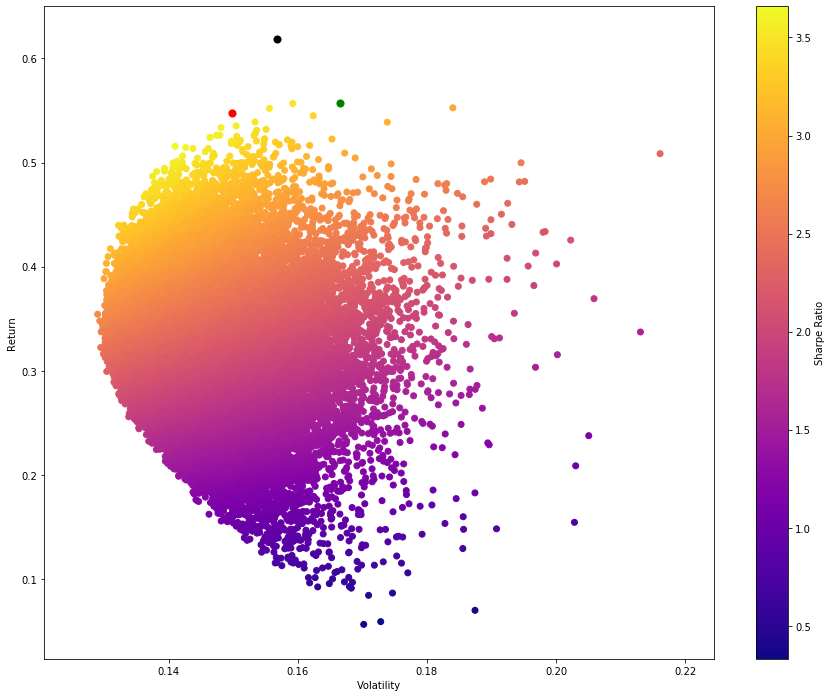

In [51]:
op = optimize_portfolio(stocks_selected, plot=True)

### Portfolio

|   Stock      |   Titles | Cost |
|--------------|----------|------|
|   AXTELCPO   |   5130   | 15566
|   Q          |   6500   |
|   SITESB-1   |   5394   |
|   FIBRAMQ    |   5134   |
|   FUNO11     |   4716   |
|   TERRA      |   5546   |

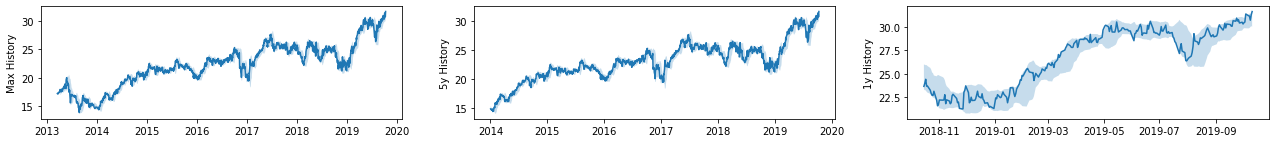

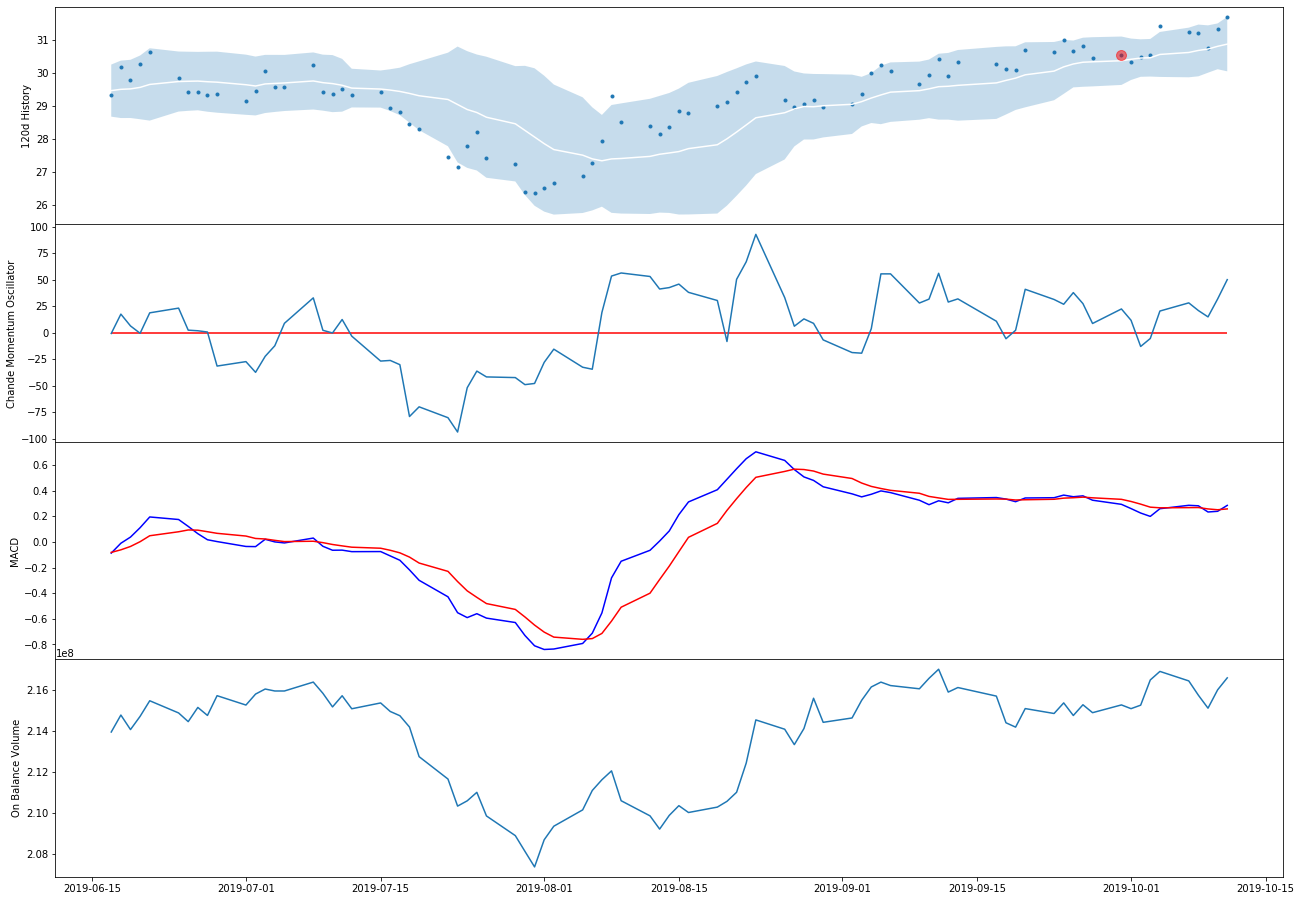

In [42]:
analyse_stock(stocks['TERRA13'], day='2019-09-30')